In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/MyDrive/Project Ml'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Project Ml


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random
import utils
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

torch.manual_seed(42)
np.random.seed(42)

In [3]:
wine = pd.read_csv('wine_reviews.csv')

In [ ]:
wine.sample(5)

,Sl.No.,Brand,Name,Reviews Date Added,Reviews do Recommend,Reviews Num Helpful,Reviews Rating,Reviews Text,Reviews Title,Weight
471,472,Zing Zang,"Zing Zang Bloody Mary Mix, 32 fl oz",2017-09-20T01:18:35Z,True,0.0,5.0,I like the product because you can drink it st...,Zing Zang bloody mary mix,NaN
1206,1207,Bittermens,Bittermens Xocolatl Mole Cocktail Bitters - 5 oz,2017-08-05T04:28:58Z,NaN,NaN,5.0,Great for a mole margarita like Tommy Bahamas ...,Five Stars,13.6 ounces
2383,2384,Carmex,"Carmex Lip Balm Original Jar - 12 PK, 12.",2017-09-23T02:53:08Z,True,NaN,5.0,I bought Carmex several years ago when I had a...,Lips and Cold Sores That Sometimes Do Not Heal,NaN
2781,2782,Vintage Wine Estates,Vintage Wine Estates 3 Bottle Harvest Collecti...,2017-11-15T17:05:21Z,NaN,NaN,5.0,This is one of the best Chards that I have had...,Great wine,NaN
2886,2887,Vintage Wine Estates,Vintage Wine Estates Kevin O'Leary's Select Re...,2018-01-02T20:20:02Z,NaN,NaN,5.0,I ordered a 3 bottle set of both the Meritage ...,Delicious !!,NaN


In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sl.No.                2890 non-null   int64  
 1   Brand                 2825 non-null   object 
 2   Name                  2890 non-null   object 
 3   Reviews Date Added    2890 non-null   object 
 4   Reviews do Recommend  1911 non-null   object 
 5   Reviews Num Helpful   626 non-null    float64
 6   Reviews Rating        2445 non-null   float64
 7   Reviews Text          2889 non-null   object 
 8   Reviews Title         2846 non-null   object 
 9   Weight                996 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 225.9+ KB


With the code below I noticed that the dataset was polluted with many non-alcoholic entries. So I started filtering these entries out.

In [ ]:
wine['Name'].value_counts()

Carmex Lip Balm Original Jar - 12 PK, 12.             1045
Bittermens Xocolatl Mole Cocktail Bitters - 5 oz       128
Zing Zang Bloody Mary Mix, 32 fl oz                     84
Clamato Original Tomato Cocktail - 64 Fl Oz Bottle      65
Great Value Original Crescent Rolls, 8 oz               57
                                                      ... 
Love Noir174 Pinot Noir - 750ml Bottle                   1
Pinot Noir - 3l Bottle - Wine Cube153                    1
Apothic174 White Blend - 750ml Bottle                    1
Handsome Devil174 Malbec - 750ml Bottle                  1
Ecco Domani174 Pinot Grigio - 750ml Bottle               1
Name: Name, Length: 332, dtype: int64

In [ ]:
unique_names = wine['Name'].unique()
print("All unique names:", unique_names)

All unique names: ['Ecco Domani174 Pinot Grigio - 750ml Bottle'
 'Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle'
 '1000 Stories174 Zinfandel - 750ml Bottle'
 'Pink Moscato - 3l Bottle - Wine Cube153'
 "Beck's174 Non Alcoholic Beer - 6pk / 12oz Bottles"
 'Apothic174 Red Blend - 750ml Bottle'
 'California Roots Moscato White Wine - 750ml'
 'Charles Charles174 Red Blend - 750ml Bottle'
 'Fancy Pants174 Sauvignon Blanc - 750ml Bottle'
 'Martini Rossi174 Asti Spumante Sparkling Wine - 750ml Bottle'
 '603174 Winni Amber Ale - 6pk / 12oz Cans'
 '603174 White Peaks Ipa - 6pk / 12oz Cans'
 'Sofia Coppola174 Riesling - 750ml Bottle'
 'California Roots Pinot Grigio White Wine - 750ml'
 'Sancho Libre174 Peach - 4pk / 12oz Cans'
 'Modern House174 With Love Red Blend - 750ml Bottle'
 'Estancia174 Cabernet Sauvignon - 750ml Bottle'
 'Voga Italia174 Pinot Grigio - 750ml Bottle'
 'Michelob174 Ultra Light Cider Beer - 6pk / 12oz Bottles'
 'Cabernet Shiraz - 3l Bottle - Wine Cube153'
 'Cabernet Sauvig

Then I did something inefficient. But I could not think of a better way to do it. I took a look at the list above and went through each of the entries by hand. I wrote down words from the entries that were not needed for the research. Then I put them into a regex to get the unnecessary rows out of my dataframe. So the words_to_filter list contains one word from the name column for each non-alcoholic entries.

In [4]:
import re

words_to_filter = ['oreo', 'master', 'pong', 'tortilla', 'gums', 'cheese', 'shampoo', 'chunks', 'blanket', 'muffins',
            'sorbate', 'sweet', 'rotomolded', 'enzyme', 'eye', 'chorizo', 'carmex', 'bagel', 'tablets', 'cooler',
            'patato', 'pancakes', 'biscuits', 'kit', 'cherry', 'rollss', 'boule', 'chalk', 'bitters']


correct_wine = wine[~wine['Name'].str.contains('|'.join(words_to_filter), case=False)]

print(len(correct_wine))

1293


To check that there were no more incorrect entries, I went over the unique_names again.

In [ ]:
unique_names = correct_wine['Name'].unique()
print("All unique names:", unique_names)

All unique names: ['Ecco Domani174 Pinot Grigio - 750ml Bottle'
 'Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle'
 '1000 Stories174 Zinfandel - 750ml Bottle'
 'Pink Moscato - 3l Bottle - Wine Cube153'
 "Beck's174 Non Alcoholic Beer - 6pk / 12oz Bottles"
 'Apothic174 Red Blend - 750ml Bottle'
 'California Roots Moscato White Wine - 750ml'
 'Charles Charles174 Red Blend - 750ml Bottle'
 'Fancy Pants174 Sauvignon Blanc - 750ml Bottle'
 'Martini Rossi174 Asti Spumante Sparkling Wine - 750ml Bottle'
 '603174 Winni Amber Ale - 6pk / 12oz Cans'
 '603174 White Peaks Ipa - 6pk / 12oz Cans'
 'Sofia Coppola174 Riesling - 750ml Bottle'
 'California Roots Pinot Grigio White Wine - 750ml'
 'Sancho Libre174 Peach - 4pk / 12oz Cans'
 'Modern House174 With Love Red Blend - 750ml Bottle'
 'Estancia174 Cabernet Sauvignon - 750ml Bottle'
 'Voga Italia174 Pinot Grigio - 750ml Bottle'
 'Michelob174 Ultra Light Cider Beer - 6pk / 12oz Bottles'
 'Cabernet Shiraz - 3l Bottle - Wine Cube153'
 'Cabernet Sauvig

In [ ]:
correct_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 2889
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sl.No.                1293 non-null   int64  
 1   Brand                 1236 non-null   object 
 2   Name                  1293 non-null   object 
 3   Reviews Date Added    1293 non-null   object 
 4   Reviews do Recommend  632 non-null    object 
 5   Reviews Num Helpful   437 non-null    float64
 6   Reviews Rating        1060 non-null   float64
 7   Reviews Text          1293 non-null   object 
 8   Reviews Title         1262 non-null   object 
 9   Weight                692 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 111.1+ KB


Here I have shortened my column titles.

In [5]:
correct_wine.columns = ['No', 'Brand', 'Name', 'Date', 'Recommendation', 'Helpful', 'Rating', 'Text', 'Title', 'Weight']

In [ ]:
correct_wine.sample(10)

,No,Brand,Name,Date,Recommendation,Helpful,Rating,Text,Title,Weight
406,407,Zing Zang,"Zing Zang Bloody Mary Mix, 32 fl oz",2017-09-02T07:55:32Z,True,4.0,5.0,Zing zang is a great drink that I supplement m...,I love zing zang,4.5 pounds
541,542,Mott's,Clamato Original Tomato Cocktail - 64 Fl Oz Bo...,2017-09-23T02:53:08Z,True,0.0,5.0,This is my favorite beverage. Do not be afraid...,Great Taste,4.445 lbs
721,722,Canada Dry,Canada Dry Ginger Ale - 1 L Bottle,2017-01-16T19:33:21Z,True,NaN,NaN,I. Have a condition that causes daily nausea N...,Best prescription for what ails the stomach,2.35 lbs
497,498,Mott's,Clamato Original Tomato Cocktail - 64 Fl Oz Bo...,2018-01-09T13:24:05Z,True,NaN,4.0,What has to happened Clamato Over the past few...,Clam Juice Is Weak,4.445 lbs
274,275,Luccio,Luccio174 Moscato D'asti - 750ml Bottle,2017-09-20T01:18:35Z,True,NaN,5.0,I tried this wine for the first time and it's ...,Sweet and smooth,0.06 lbs
1423,1424,Great Value,"Great Value Original Crescent Rolls, 8 oz",2017-09-02T07:55:36Z,True,0.0,4.0,These crescent rolls baked up flaky and butter...,Yummy,NaN
115,116,Mirassou,Mirassou174 Pinot Noir - 750ml Bottle,2018-01-10T05:58:02Z,True,1.0,4.0,Very good summer red. It's become our favorite...,Smooth And Fruity.,1.0 lbs
625,626,KNOB CREEK,"Knob Creek Kentucky Straight Bourbon Whiskey, ...",2017-09-20T01:18:35Z,NaN,NaN,4.0,I AM A SINGLE MALT SCOTCH AFICIANADO. RECENTLY...,From scotch to bourbon,NaN
603,604,Mr. & Mrs. T,"Mr _ Mrs T Bold _ Spicy Bloody Mary Mix, 1.75 L",2017-09-06T04:49:34Z,True,NaN,5.0,Can't beat the deal! This review was collected...,Best price I've ever paid!,NaN
460,461,Jim Beam,"Jim Beam Black Bourbon Whiskey, 50 mL",2017-09-20T01:18:35Z,NaN,NaN,5.0,I bought this in early December and it didn't ...,Jim Beam at it's best!,NaN


In [10]:
correct_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060 entries, 0 to 2889
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   No              1060 non-null   int64  
 1   Brand           1003 non-null   object 
 2   Name            1060 non-null   object 
 3   Date            1060 non-null   object 
 4   Recommendation  554 non-null    object 
 5   Helpful         437 non-null    float64
 6   Rating          1060 non-null   float64
 7   Text            1060 non-null   object 
 8   Title           1029 non-null   object 
 9   Weight          512 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 91.1+ KB


At this point, I started to check if there were no empty entries in the important columns. There were 233 empty entries in the Reviews Rating column. I decided to remove these rows. I could have chosen to implement the average value from the Rating column, but this would have deprived me of the ability to do a classification analysis. So I decided against this and removed the rows with missing values.

In [6]:
correct_wine = correct_wine.dropna(subset=['Rating'])

In [9]:
correct_wine['Rating'].unique()

array([5., 3., 2., 4., 1.])

In [7]:
correct_wine.shape

(1060, 10)

This is a check of the distribution of the rating column. And there seems to be great class inequality.

In [8]:
correct_wine['Rating'].value_counts(normalize=True)

5.0    0.798113
4.0    0.106604
1.0    0.043396
2.0    0.028302
3.0    0.023585
Name: Rating, dtype: float64

There are not many useful columns that I can base my model on when I look at the data after all the preprocessing. The most useful one is the text column. I can analyse it using vectorization. So my machine learning model will predict the rating of the alcoholic product based on the text column.

vectorization

Here i am adding the stratify=y parameter, to ensure that the split maintains the same distribution of ratings in both the training and testing sets.

In [ ]:
X = correct_wine['Text']
y = correct_wine['Rating']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=.5, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((530,), (530,), (530,), (530,))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import SGDRegressor
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

Knowing that the rating has major imbalances, I gave the different classes weights based on their frequency of occurrence.

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
print(class_weight_dict)

{1.0: 4.608695652173913, 2.0: 7.066666666666666, 3.0: 8.153846153846153, 4.0: 1.8928571428571428, 5.0: 0.25059101654846333}


I created the processing steps for my pipeline, experimenting with various options. I tried using TfidfVectorizer and explored models such as GradientBoostingClassifier and RandomForestClassifier. But i got the best result from the pipeline below even though this also did not grant great results.

In [ ]:
vect = CountVectorizer()
scaler = MaxAbsScaler()
clf = SGDClassifier(random_state=42, class_weight=class_weight_dict)

pipe = make_pipeline(vect, scaler, clf)

In [ ]:
pipe.named_steps

{'countvectorizer': CountVectorizer(),
 'maxabsscaler': MaxAbsScaler(),
 'sgdclassifier': SGDClassifier(class_weight={1.0: 4.608695652173913, 2.0: 7.066666666666666,
                             3.0: 8.153846153846153, 4.0: 1.8928571428571428,
                             5.0: 0.25059101654846333},
               random_state=42)}

In [ ]:
params = [{
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'countvectorizer__max_features': [3000, 5000, 7000],
    'countvectorizer__stop_words': [None, 'english'],
    'sgdclassifier__penalty': ['l1', 'l2'],
    'sgdclassifier__alpha': [0.0001, 0.01, 0.1],
    'sgdclassifier__l1_ratio': [0.15, 0.5, 0.8],
    'sgdclassifier__loss': ['hinge', 'log', 'modified_huber'],
    'sgdclassifier__learning_rate': ['adaptive', 'optimal'],
    'sgdclassifier__eta0': [0.1, 0.01, 0.001],
    'sgdclassifier__max_iter': [100, 200, 300],
}]

In [ ]:
gs = GridSearchCV(pipe, params, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 17496 candidates, totalling 87480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=2000)),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight={1.0: 4.608695652173913,
                                                                    2.0: 7.066666666666666,
                                                                    3.0: 8.153846153846153,
                                                                    4.0: 1.8928571428571428,
                                                                    5.0: 0.25059101654846333},
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'countvectorizer_...
                          'countvectorizer__stop_words': [None, 'english'],
                          'sgdclassifier__alpha': [0.0001, 0.01, 0.1],
                          'sgdclassifier__eta0': [0.1, 0.01, 0.001],
                          'sgdclassifier__l1_ratio': [0.15, 0.5, 0.8],
                          'sgdclassifier__learning_rate': ['adaptive',
                                                           'optimal'],
                          'sgdclassifier__loss': ['hinge', 'log',
                                                  'modified_huber'],
                          'sgdclassifier__max_iter': [100, 200, 300],
                          'sgdclassifier__penalty': ['l1', 'l2']}],
             scoring='f1_macro', verbose=1)

In [ ]:
gs.best_score_

0.3725988029979256

In [ ]:
gs.best_params_

{'countvectorizer__max_features': 5000,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': None,
 'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__eta0': 0.1,
 'sgdclassifier__l1_ratio': 0.15,
 'sgdclassifier__learning_rate': 'adaptive',
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__max_iter': 100,
 'sgdclassifier__penalty': 'l1'}

In [ ]:
y_test_pred = gs.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.28      0.30      0.29        23
         2.0       0.09      0.13      0.11        15
         3.0       0.10      0.08      0.09        12
         4.0       0.27      0.14      0.18        57
         5.0       0.86      0.90      0.88       423

    accuracy                           0.75       530
   macro avg       0.32      0.31      0.31       530
weighted avg       0.73      0.75      0.74       530



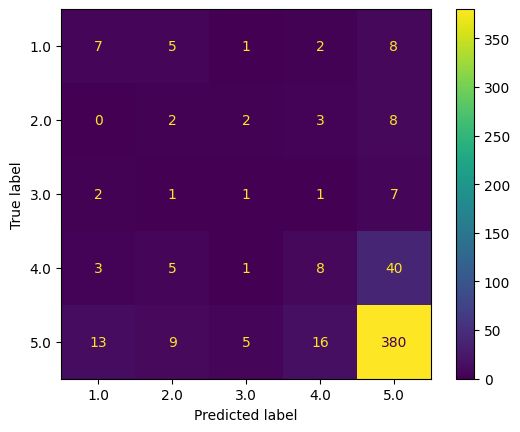

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
scores
print(f"Mean {scores.mean()}, Std {scores.std()}")

Mean 0.3027848985380813, Std 0.03928672919791165


Neural network

In [ ]:
correct_wine['Brand'] = correct_wine['Brand'].fillna('')
correct_wine['Title'] = correct_wine['Title'].fillna('')

In [ ]:
correct_wine['Combined_Column'] = correct_wine['Brand'] + ' ' + correct_wine['Text'] + ' ' + correct_wine['Title']

Here the text columns have been combined. My thought process was that neural networks are better suited for more complex data. Now with the deadline approaching, I wonder why I did not do this for the machine learning model.

In [ ]:
XX = correct_wine['Combined_Column']
YY = correct_wine['Rating']

In [ ]:
XX.shape

(1060,)

In [ ]:
YY.shape

(1060,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size=0.5, random_state=42, stratify=YY)

In [ ]:
from collections import Counter
cnt = Counter(list(YY))
num_classes = 6
cnt.most_common(num_classes)

[(5.0, 846), (4.0, 113), (1.0, 46), (2.0, 30), (3.0, 25)]

Here i had to change the number of classes to 6 in order for the code to work. If i put 5 i kept getting a CUDA error, i have not figured out why this is the case.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train = tfidf_vectorizer.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

X_train = X_train_resampled.todense()
X_test = tfidf_vectorizer.transform(X_test).todense()


Y_train = np.asarray(y_train_resampled)
Y_test = np.asarray(Y_test)

X_test, X_dev, Y_test, Y_dev = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_dev.shape)
print(Y_test.shape)

(2115, 2406)
(265, 2406)
(265, 2406)
(2115,)
(265,)
(265,)


To deal with the class imbalance, I used the SMOTE resampler to try and correct it. This did not really work as planned. However, I did change the model so that it was not just thinking that everything was going to be a 5 out of 5. This caused the overall accuracy to go down, but the weighted average to go up.

In [ ]:
def np2iter(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.float)
  # y = np.expand_dims(y, axis=1)
  y = torch.tensor(y, dtype=torch.long)
  print(y.shape)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=32, shuffle=shuffle)

train_iter = np2iter(X_train, Y_train, shuffle=True)
dev_iter =  np2iter(X_dev, Y_dev, shuffle=False)
test_iter =  np2iter(X_test, Y_test, shuffle=False)

torch.Size([2115])
torch.Size([265])
torch.Size([265])


In [ ]:
max(Y_test)

5.0

In [ ]:
class MultiClassModel(nn.Module):
  def __init__(self, in_features, out_features):
    super(MultiClassModel, self).__init__()
    self.layer = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, XX):
    return self.layer(XX)

This is where I played around with different learning rates and different epochs. 50 is clearly way too much, but I decided to keep this model in so that I could compare the other models with this inaccurate one.

In [ ]:
from sklearn.metrics import accuracy_score

def val_acc(Y_pred, Y_test):
  y_pred = np.argmax(Y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=Y_test)


classification_model = MultiClassModel(in_features=X_train.shape[1], out_features=num_classes)
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=50)

epoch 1 train loss: 1.6949 val_cls: 1.6881 val_acc: 0.1585
epoch 2 train loss: 1.5731 val_cls: 1.6320 val_acc: 0.3698
epoch 3 train loss: 1.4922 val_cls: 1.5688 val_acc: 0.6453
epoch 4 train loss: 1.4245 val_cls: 1.5354 val_acc: 0.6792
epoch 5 train loss: 1.3645 val_cls: 1.4532 val_acc: 0.7434
epoch 6 train loss: 1.3103 val_cls: 1.4509 val_acc: 0.7094
epoch 7 train loss: 1.2596 val_cls: 1.3929 val_acc: 0.7358
epoch 8 train loss: 1.2136 val_cls: 1.3833 val_acc: 0.7019
epoch 9 train loss: 1.1702 val_cls: 1.3939 val_acc: 0.6792
epoch 10 train loss: 1.1302 val_cls: 1.3293 val_acc: 0.7321
epoch 11 train loss: 1.0927 val_cls: 1.3135 val_acc: 0.7245
epoch 12 train loss: 1.0577 val_cls: 1.2958 val_acc: 0.7245
epoch 13 train loss: 1.0244 val_cls: 1.2901 val_acc: 0.6830
epoch 14 train loss: 0.9937 val_cls: 1.2460 val_acc: 0.7321
epoch 15 train loss: 0.9646 val_cls: 1.2640 val_acc: 0.6792
epoch 16 train loss: 0.9374 val_cls: 1.2415 val_acc: 0.7057
epoch 17 train loss: 0.9114 val_cls: 1.2307 val_a

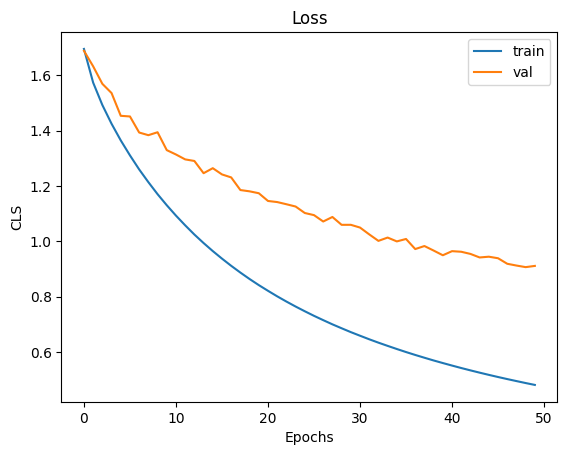

In [ ]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_cls"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('CLS');
plt.legend();

So the model is overfitting big time, a problem that did not really go away.

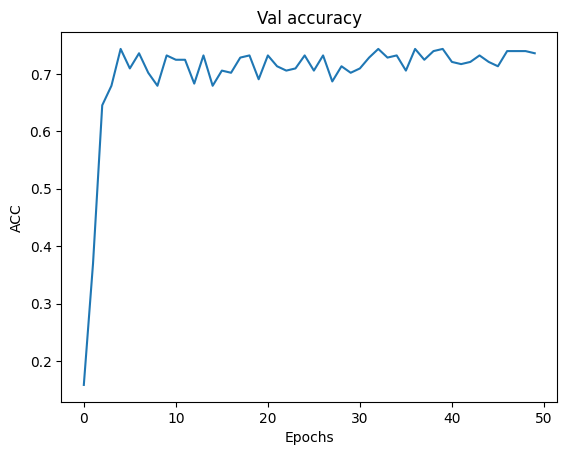

In [ ]:
plt.plot(history["val_acc"])
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC');

In [ ]:
pred = utils.test(classification_model, test_iter)

In [ ]:
conv_pred = np.argmax(pred, axis=1)
conv_pred[:10]

tensor([5, 2, 5, 5, 5, 4, 5, 5, 5, 4])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(y_pred=conv_pred, y_true=Y_test));

              precision    recall  f1-score   support

         1.0       0.33      0.36      0.35        11
         2.0       0.20      0.38      0.26         8
         3.0       0.25      0.17      0.20         6
         4.0       0.27      0.29      0.28        28
         5.0       0.88      0.84      0.86       212

    accuracy                           0.74       265
   macro avg       0.39      0.41      0.39       265
weighted avg       0.76      0.74      0.74       265



So poor accuracy, but at least the model spread its answers.

In [ ]:
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

Accuracy:  0.7358490566037735 , MSE:  1.1962264150943396 , MAE 0.47924528301886793


Hidden layers were introduced here. Surprisingly, they made the model a little worse.

In [ ]:
class Model2(nn.Module):
  def __init__(self):
    super(Model2, self).__init__()
    self.layer = nn.Sequential(
        nn.Linear(in_features=X_train.shape[1], out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=num_classes)
    )


  def forward(self, x):
    return self.layer(x)

classification_model = Model2()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=50,
                            early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 1.7178 val_cls: 1.6162 val_acc: 0.7962
tensor(1.6162) None
epoch 2 train loss: 1.6541 val_cls: 1.6491 val_acc: 0.0302
tensor(1.6491) tensor(1.6162)
epoch 3 train loss: 1.6315 val_cls: 1.6861 val_acc: 0.0453
tensor(1.6861) tensor(1.6162)
epoch 4 train loss: 1.6187 val_cls: 1.5954 val_acc: 0.0566
tensor(1.5954) tensor(1.6162)
epoch 5 train loss: 1.6074 val_cls: 1.6937 val_acc: 0.0453
tensor(1.6937) tensor(1.5954)
epoch 6 train loss: 1.5910 val_cls: 1.4714 val_acc: 0.7962
tensor(1.4714) tensor(1.5954)
epoch 7 train loss: 1.5516 val_cls: 1.6383 val_acc: 0.0491
tensor(1.6383) tensor(1.4714)
epoch 8 train loss: 1.4452 val_cls: 1.1975 val_acc: 0.4679
tensor(1.1975) tensor(1.4714)
epoch 9 train loss: 1.2355 val_cls: 1.3262 val_acc: 0.1170
tensor(1.3262) tensor(1.1975)
epoch 10 train loss: 0.9822 val_cls: 1.3329 val_acc: 0.1094
tensor(1.3329) tensor(1.1975)
epoch 11 train loss: 0.7257 val_cls: 1.3346 val_acc: 0.1019
tensor(1.3346) tensor(1.1975)
epoch 12 train loss: 0.5260 v

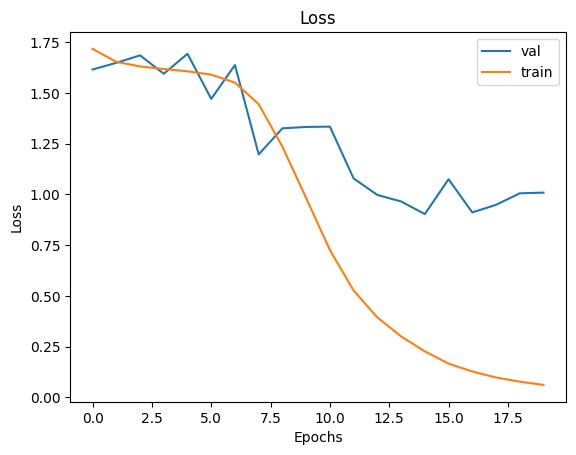

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The introduction of the early stopper did however prevent a little of the overfitting.

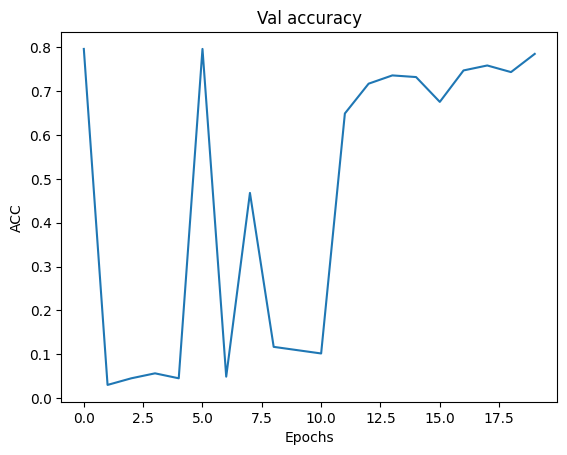

In [ ]:
plt.plot(history["val_acc"])
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC');

In [ ]:
class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

Accuracy:  0.7245283018867924 , MSE:  2.0037735849056606 , MAE 0.6452830188679245


In [ ]:
pred = utils.test(classification_model, test_iter)
conv_pred = np.argmax(pred, axis=1)
conv_pred[:10]
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(y_pred=conv_pred, y_true=Y_test));
class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

              precision    recall  f1-score   support

         1.0       0.18      0.73      0.29        11
         2.0       0.33      0.12      0.18         8
         3.0       0.25      0.17      0.20         6
         4.0       0.30      0.11      0.16        28
         5.0       0.88      0.84      0.86       212

    accuracy                           0.72       265
   macro avg       0.39      0.39      0.34       265
weighted avg       0.76      0.72      0.73       265

Accuracy:  0.7245283018867924 , MSE:  2.0037735849056606 , MAE 0.6452830188679245


This was ultimatly the best model. I introduced the Adam optimizer and that did seem to make a difference.

In [ ]:
class Model3(nn.Module):
  def __init__(self):
    super(Model3, self).__init__()
    self.layer =nn.Sequential(nn.Linear(in_features=X_train.shape[1], out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=num_classes))


  def forward(self, x):
    return self.layer(x)

classification_model = Model3()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=0.001),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=50,
                            early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 1.7358 val_cls: 1.6156 val_acc: 0.7925
tensor(1.6156) None
epoch 2 train loss: 1.1187 val_cls: 1.3233 val_acc: 0.5132
tensor(1.3233) tensor(1.6156)
epoch 3 train loss: 0.4041 val_cls: 0.8288 val_acc: 0.7698
tensor(0.8288) tensor(1.3233)
epoch 4 train loss: 0.1576 val_cls: 0.6795 val_acc: 0.7811
tensor(0.6795) tensor(0.8288)
epoch 5 train loss: 0.0699 val_cls: 0.6733 val_acc: 0.7962
tensor(0.6733) tensor(0.6795)
epoch 6 train loss: 0.0377 val_cls: 0.6988 val_acc: 0.7925
tensor(0.6988) tensor(0.6733)
epoch 7 train loss: 0.0236 val_cls: 0.7278 val_acc: 0.7925
tensor(0.7278) tensor(0.6733)
epoch 8 train loss: 0.0163 val_cls: 0.7716 val_acc: 0.7962
tensor(0.7716) tensor(0.6733)
epoch 9 train loss: 0.0120 val_cls: 0.7927 val_acc: 0.7925
tensor(0.7927) tensor(0.6733)
epoch 10 train loss: 0.0092 val_cls: 0.8311 val_acc: 0.7925
tensor(0.8311) tensor(0.6733)
EARLY STOPPING 


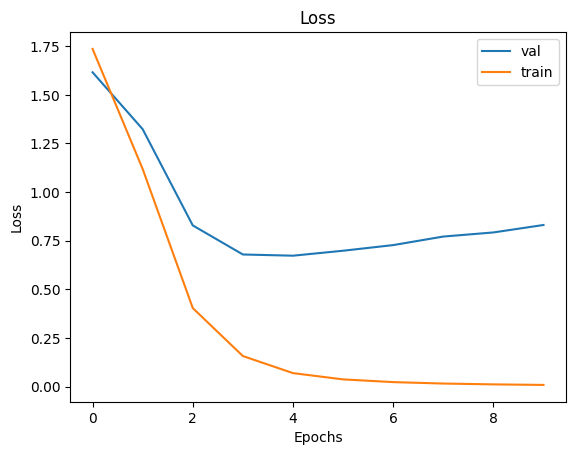

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Stil major overfitting that i could not fix.

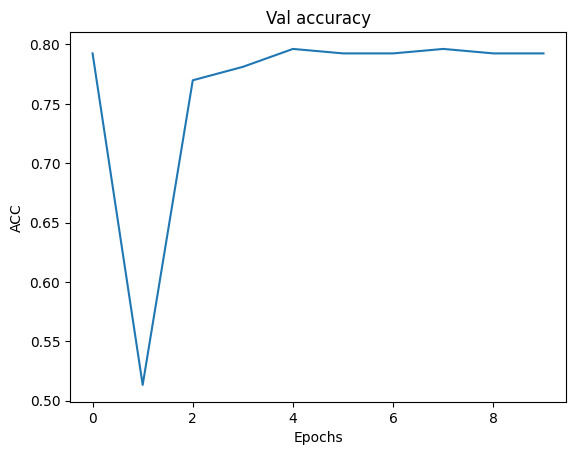

In [ ]:
plt.plot(history["val_acc"])
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC');

In [ ]:
class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

Accuracy:  0.7924528301886793 , MSE:  1.0716981132075472 , MAE 0.4


In [ ]:
pred = utils.test(classification_model, test_iter)
conv_pred = np.argmax(pred, axis=1)
conv_pred[:10]
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(y_pred=conv_pred, y_true=Y_test));
class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

              precision    recall  f1-score   support

         1.0       0.67      0.18      0.29        11
         2.0       0.50      0.12      0.20         8
         3.0       1.00      0.17      0.29         6
         4.0       0.38      0.21      0.27        28
         5.0       0.82      0.94      0.88       212

    accuracy                           0.79       265
   macro avg       0.67      0.33      0.38       265
weighted avg       0.76      0.79      0.76       265

Accuracy:  0.7924528301886793 , MSE:  1.0716981132075472 , MAE 0.4


In [ ]:
class Model4(nn.Module):
  def __init__(self):
    super(Model4, self).__init__()
    self.layer = nn.Sequential(nn.Dropout(p=0.7),
                               nn.Linear(in_features=X_train.shape[1], out_features=100),
                                nn.Dropout(p=0.7),
                                nn.ReLU(),
                                nn.Linear(in_features=100, out_features=100),
                                nn.Dropout(p=0.7),
                                nn.ReLU(),
                                nn.Linear(in_features=100, out_features=num_classes))


  def forward(self, x):
    return self.layer(x)

In [ ]:
classification_model = Model4()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(classification_model.parameters(), lr=0.01),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=100,
                            early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 1.2094 val_cls: 1.1088 val_acc: 0.3736
tensor(1.1088) None
epoch 2 train loss: 0.5550 val_cls: 0.7668 val_acc: 0.7585
tensor(0.7668) tensor(1.1088)
epoch 3 train loss: 0.4440 val_cls: 0.7605 val_acc: 0.7170
tensor(0.7605) tensor(0.7668)
epoch 4 train loss: 0.4024 val_cls: 0.7578 val_acc: 0.7094
tensor(0.7578) tensor(0.7605)
epoch 5 train loss: 0.3903 val_cls: 0.6480 val_acc: 0.7736
tensor(0.6480) tensor(0.7578)
epoch 6 train loss: 0.3659 val_cls: 0.6901 val_acc: 0.7245
tensor(0.6901) tensor(0.6480)
epoch 7 train loss: 0.3445 val_cls: 0.6345 val_acc: 0.7547
tensor(0.6345) tensor(0.6480)
epoch 8 train loss: 0.3158 val_cls: 0.6964 val_acc: 0.7170
tensor(0.6964) tensor(0.6345)
epoch 9 train loss: 0.3225 val_cls: 0.6458 val_acc: 0.7660
tensor(0.6458) tensor(0.6345)
epoch 10 train loss: 0.3082 val_cls: 0.6455 val_acc: 0.7396
tensor(0.6455) tensor(0.6345)
epoch 11 train loss: 0.2925 val_cls: 0.7230 val_acc: 0.7358
tensor(0.7230) tensor(0.6345)
epoch 12 train loss: 0.2846 v

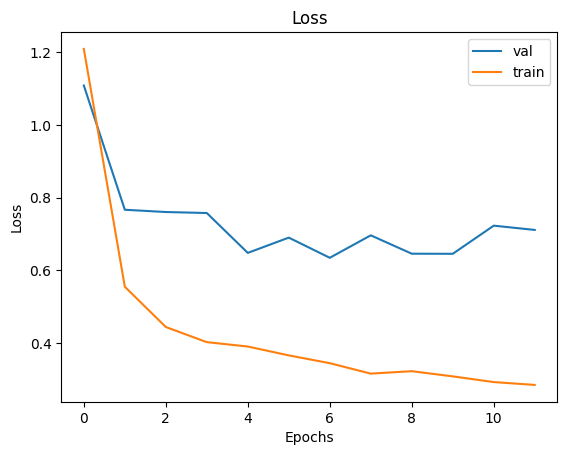

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

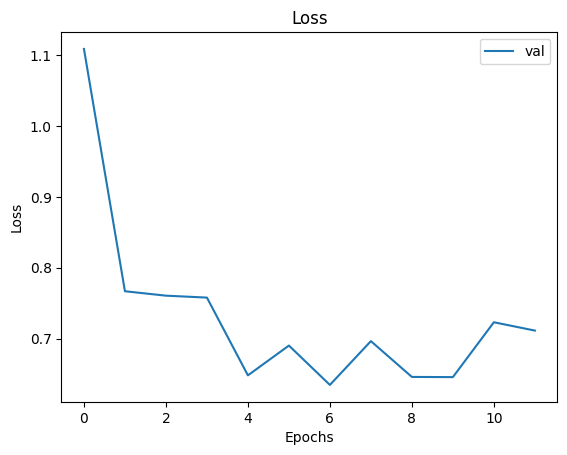

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

Accuracy:  0.7509433962264151 , MSE:  1.120754716981132 , MAE 0.4490566037735849


In [ ]:
pred = utils.test(classification_model, test_iter)
conv_pred = np.argmax(pred, axis=1)
conv_pred[:10]
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(y_pred=conv_pred, y_true=Y_test));
class_predictions = utils.test(classification_model, test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=Y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=Y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=Y_test, y_pred=class_predictions))

              precision    recall  f1-score   support

         1.0       0.33      0.36      0.35        11
         2.0       0.14      0.12      0.13         8
         3.0       0.33      0.17      0.22         6
         4.0       0.25      0.25      0.25        28
         5.0       0.87      0.88      0.87       212

    accuracy                           0.75       265
   macro avg       0.38      0.36      0.36       265
weighted avg       0.74      0.75      0.75       265

Accuracy:  0.7509433962264151 , MSE:  1.120754716981132 , MAE 0.4490566037735849
